# Simulationg fibrosis

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:
def generate_laplacian(N, M, conduction_block_threshold, boundary_condition="no-flux", sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks in JAX
    key = random.PRNGKey(seed)
    conduction_blocks = random.uniform(key, (N, M)) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    

    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])
    
    
    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

        # Apply boundary conditions
        if boundary_condition == "no-flux":
            valid = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
        elif boundary_condition == "periodic":
            ni %= N
            nj %= M
            valid = np.ones_like(ni, dtype=bool)
        
        # Apply conduction block constraints
        valid &= ~conduction_blocks[ni % N, nj % M]
        valid &= ~conduction_blocks[indices[:, 0], indices[:, 1]]
        
        # Gather indices and weights for valid connections
        adj_rows.extend(idx[valid])
        adj_cols.extend(node_index(ni[valid], nj[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))  


    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))

    # Calculate the degree matrix
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Enforce no flux for conduction blocks
    conduction_block_indices = idx[conduction_blocks.flatten()]
    adj_matrix = adj_matrix.tolil()
    adj_matrix[conduction_block_indices, :] = 0
    adj_matrix[:, conduction_block_indices] = 0
    degree_matrix = degree_matrix.tolil()
    degree_matrix[conduction_block_indices, conduction_block_indices] = 0

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Return in sparse or dense JAX format
    if sparse_matrix:
        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), conduction_blocks
    else:
        return jnp.array(laplacian_matrix.todense()), conduction_blocks
N_x=200
N_y=200
L1, c1=generate_laplacian(N_x, N_x, 0, boundary_condition="no-flux", sparse_matrix=True)
#plt.imshow(L1.todense())

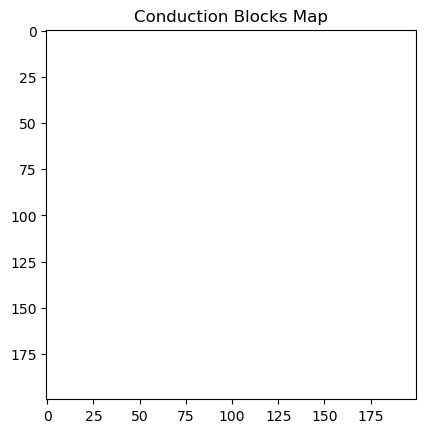

In [3]:

from matplotlib.colors import ListedColormap

# Replace True values with NaN
c1_nan = np.where(c1, np.nan, c1)
# Create c_map where NaN in c1_nan is 1 and False is 0
c_map = np.where(np.isnan(c1_nan), 1, 0)
# Define a custom colormap with white for 0 and blue for 1
color = ListedColormap(['white', 'blue'])

plt.imshow(c_map, cmap=color)
#plt.colorbar()
plt.title('Conduction Blocks Map')
plt.show()


In [3]:

def FHN_graph(t, y, args):
    N, a, b, e, Du,L= args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)


In [4]:
#switched from Dopri5 to Dopri8 cause the former was getting stuck

def solve_heart(y0='wave', a=3, b=0.2, e=1e-2, Du=0.2, T=300, L=L1, max_steps=1000000,dts=6000,
                solver=diffrax.Dopri8(), rtol=1e-5, atol=1e-6, dt0=1e-2):
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        for i in range(N):
            if i % N_x == 0:
                y0 = y0.at[i].set(0.4)

    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, dts))  # Reduced save points
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    # Switch to a less memory-intensive solver, e.g., Tsit5 or BDF
    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N, a, b, e, Du, L),
                      saveat=saveat, max_steps=max_steps, stepsize_controller=stepsize_controller)

    return sol


In [5]:
N=N_x*N_x
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,boundary_condition="no-flux",sparse_matrix=True, seed=2)

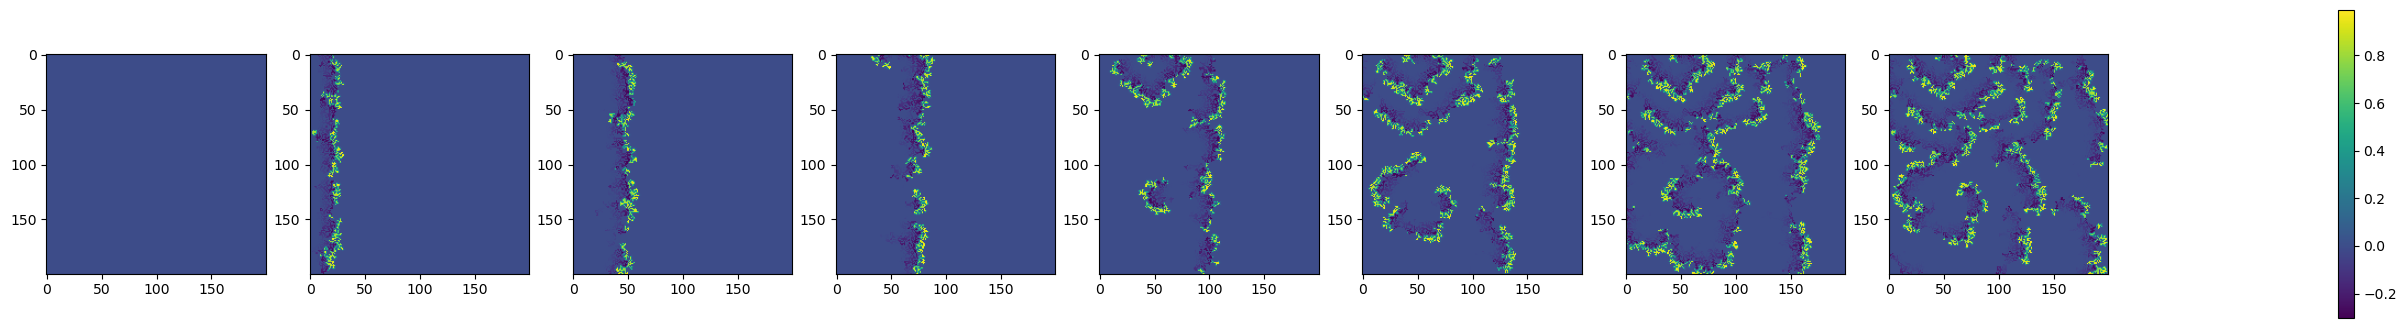

In [6]:

N_y=200
N=N_x*N_y
dts=6000
sol = solve_heart(T=3000,a=3,b=0.05,Du=0.04, L=L1, dts=dts)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
#To have arrhythmias; a=3, b=0.05, Du=0.04, cd=0.5. With cd=0.59 I don't have conduction anymore

In [8]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T

u_sol=u_sol.reshape(200, 200, 6000)
v_sol=v_sol.reshape(200, 200, 6000)


In [ ]:
#functions calculating average entropy in the frequency power spectrum of elements 
#which are not conduction blocks

@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12
    power_spectrum /= jnp.sum(power_spectrum) + epsilon
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))
    return entropy

@jit
def process_element(array, i, j):
    fft_result = jnp.fft.fft(array[i, j, :])
    power_spectrum = jnp.abs(fft_result) ** 2
    entropy = calculate_entropy(power_spectrum)
    return entropy


def average_entropy(array, mask):
    N, _, T = array.shape
    valid_indices = jnp.array(jnp.where(~mask)).T
    
    vectorized_process = vmap(lambda idx: process_element(array, idx[0], idx[1]))
    entropy_values = vectorized_process(valid_indices)
    
    average_entropy = jnp.mean(entropy_values)
    return average_entropy

In [22]:
print(average_entropy(u_sol, c1))

4.005181


In [ ]:
results_u = []
results_v=[]

# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.1):
    seed = int(conduction_threshold * 10)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold,boundary_condition="no-flux",sparse_matrix=True, seed=seed)
    
    sol = solve_heart(T=3000,a=3,b=0.05,Du=0.04, L=L1, dts=dts)
    u_sol = sol.ys[:,:N].T 
    v_sol = sol.ys[:,N:].T

    u_sol=u_sol.reshape(200, 200, 6000)
    v_sol=v_sol.reshape(200, 200, 6000)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

# Dominant frequency analysis


In [ ]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T
def dominant_frequency(arr, sampling_rate):
    """
    Computes the dominant frequency (frequency with max amplitude) for each point in a 2D array.

    Parameters:
        arr (ndarray): Input array with shape (N, T), where N is the number of points
                       and T is the time series length for each point.
        sampling_rate (float): Sampling rate of the time series data.

    Returns:
        ndarray: Array of dominant frequencies for each point, shape (N,).
    """
    # Compute Fourier Transform along the temporal axis (axis=1)
    fft_vals = jnp.fft.fft(arr, axis=1)
    
    # Compute the frequency bins
    freqs = jnp.fft.fftfreq(arr.shape[1], d=1/sampling_rate)
    
    # Take the amplitude of the FFT
    amplitude_spectrum = jnp.abs(fft_vals)
    
    # Only take the positive half of frequencies for analysis
    half_length = arr.shape[1] // 2
    freqs = freqs[:half_length]
    amplitude_spectrum = amplitude_spectrum[:, :half_length]
    
    # Find index of the max amplitude for each point
    max_indices = jnp.argmax(amplitude_spectrum, axis=1)
    
    # Map indices to corresponding frequencies
    dominant_freqs = freqs[max_indices]
    
    return dominant_freqs
freq_u=dominant_frequency(u_sol, 2)
freq_v=dominant_frequency(v_sol, 2)

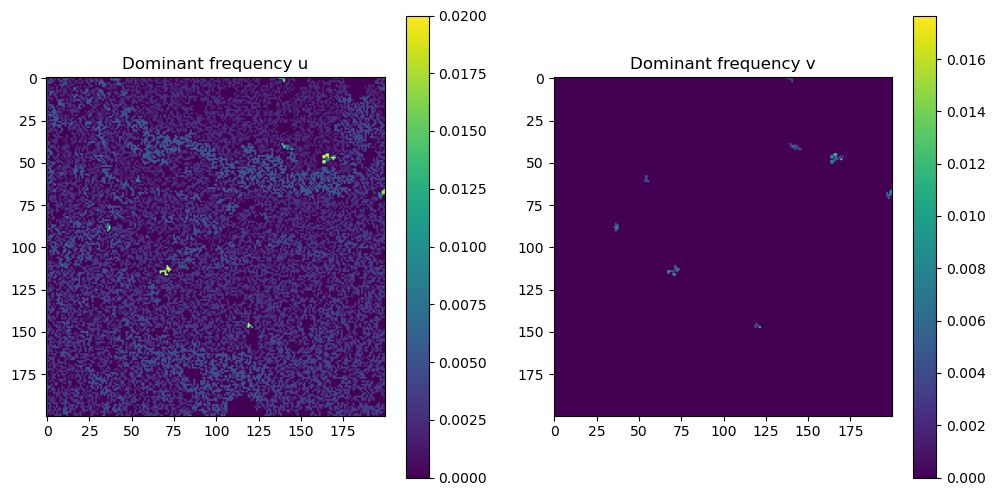

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot freq_u
im1 = axs[0].imshow(freq_u.reshape(N_x, N_y), cmap='viridis')
axs[0].set_title('Dominant frequency u')
fig.colorbar(im1, ax=axs[0])

# Plot freq_v
im2 = axs[1].imshow(freq_v.reshape(N_x, N_y), cmap='viridis')
axs[1].set_title('Dominant frequency v')
fig.colorbar(im2, ax=axs[1])

plt.show()

# Phase and topological charge

In [ ]:
# function telling me which points have (u,v)=(0,0) for all t

def zero_mask_over_T(array):
    """
    Returns a mask with True values corresponding to elements in S that are always 0 over T.
    
    Parameters:
    array (numpy.ndarray): Input array of shape (S, T).
    
    Returns:
    numpy.ndarray: Mask of shape (S,) with True values where elements in S are always 0 over T.
    """
    # Check if all elements across the T dimension are zero
    mask = (array == 0).all(axis=1)
    return mask


mask = zero_mask_over_T(u_sol)
print(mask)

[False  True False ...  True  True  True]


In [9]:
#Updated Philip code

def compute_top_charge(phase_data):
    
    rows, cols, frames = phase_data.shape
    
    # Offsets for the 8-point integration path around each point
    k_offsets = [1, 1, 0, -1, -1, -1, 0, 1]
    l_offsets = [0, 1, 1, 1, 0, -1, -1, -1]

    # Define the phase difference function with range [-π, π]
    def phase_difference(theta1, theta2):
        return (jnp.mod(theta1 - theta2 + jnp.pi, 2 * jnp.pi) - jnp.pi)

    # Compute the topological charge at a single point (i, j) for a given frame
    def compute_integral(i, j, phase_frame):
        integral_sum = 0.0

        # Iterate over each segment of the path
        for m in range(8):  
            # Current point in the path
            y1, x1 = i + k_offsets[m], j + l_offsets[m]
            # Next point in the path (wrapping around with (m + 1) % 8)
            y2, x2 = i + k_offsets[(m + 1) % 8], j + l_offsets[(m + 1) % 8]

            # Compute the phase difference along the segment
            diff_theta = phase_difference(phase_frame[y2, x2], phase_frame[y1, x1])
            integral_sum += diff_theta

        # Normalize by 2π to get topological charge in [-1, 1]
        return integral_sum / (2 * jnp.pi)


    def process_frame(t):
        phase_frame = phase_data[:, :, t]

        # Create meshgrid for row and column indices within the frame (ignore boundary points)
        i_coords, j_coords = jnp.meshgrid(jnp.arange(1, rows - 1), jnp.arange(1, cols - 1), indexing='ij')

        compute_integral_vmap = jax.vmap(
            jax.vmap(compute_integral, in_axes=(0, 0, None)),  # Apply over rows (i) and columns (j)
            in_axes=(0, 0, None)  # Matching in_axes for row and column vectors
        )

        # Compute result for each (i, j) in the frame
        result = compute_integral_vmap(i_coords, j_coords, phase_frame)
        return result


    topological_charge = jax.vmap(process_frame)(jnp.arange(frames))
    return topological_charge


In [10]:
def coarse_grain(array, mask):
    """
    Coarse-grain each frame of the 3D array by averaging each node with its 8 neighbors,
    using a 2D mask where `True` indicates invalid values to exclude
    from the average calculation. The mask is applied uniformly across all time frames.
    
    Parameters:
    - array: 3D array of shape (height, width, T), where each (height, width)
             slice along the third dimension represents a frame.
    - mask: 2D boolean array of shape (height, width) where `True` indicates
             values to exclude, and `False` indicates valid values.
    
    Returns:
    - A coarse-grained 3D array of the same shape as `array`.
    """
    # Define a 3x3 filter for counting valid neighbors
    valid_filter = jnp.ones((3, 3, 1, 1))  

    # Add a third axis to the mask to match (height, width, 1)
    mask = mask[..., None] 

    def process_frame(frame):
        # Add an extra dimension to match convolution requirements (height, width, 1)
        frame = frame[..., None]
        
        # Invert mask to interpret True as NaN and False as valid
        inverted_mask = ~mask  
        
        # Replace NaN with 0 for convolution calculation
        frame_no_nan = jnp.where(inverted_mask, frame, 0.0)
        
        # Sum valid values in the 3x3 neighborhood
        sum_values = lax.conv_general_dilated(
            frame_no_nan[None, ...],  # Shape: (1, height, width, 1)
            valid_filter,  # Filter to sum values
            window_strides=(1, 1),  
            padding="SAME",  # Pad to keep original size
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]  # Drop added dims
        
        # Count of valid neighbors based on inverted mask
        count_valid = lax.conv_general_dilated(
            inverted_mask.astype(jnp.float32)[None, ...],  # True->1, False->0 for counting
            valid_filter,  # Same filter to count valid entries
            window_strides=(1, 1),
            padding="SAME",
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]
        
        # Calculate average ignoring invalid
        coarse_grained_frame = sum_values / count_valid
        
        # Set result to NaN where all neighbors are invalid
        coarse_grained_frame = jnp.where(count_valid == 0, jnp.nan, coarse_grained_frame)
        
        # Restore original values outside the mask
        coarse_grained_frame = jnp.where(inverted_mask[..., 0], coarse_grained_frame, frame[..., 0])
        
        return coarse_grained_frame

    # Apply the process_frame function to each frame in the 3D array
    coarse_grained_array = jnp.stack([process_frame(array[..., t]) for t in range(array.shape[-1])], axis=-1)
    
    return coarse_grained_array

# Coarse graining

In [ ]:
u_sol=u_sol.reshape(200, 200, 6000)
v_sol=v_sol.reshape(200, 200, 6000)

u_coarse_grained = coarse_grain(u_sol, c1)
u_coarse_grained = u_coarse_grained.reshape(200*200, -1)


v_coarse_grained = coarse_grain(v_sol, c1)
v_coarse_grained = v_coarse_grained.reshape(200*200, -1)


In [ ]:
# Check for NaN values in u_coarse_grained

if jnp.isnan(u_coarse_grained).any():
    print("NaN values found in u_coarse_grained")

# Check for NaN values in v_coarse_grained
if jnp.isnan(v_coarse_grained).any():
    print("NaN values found in v_coarse_grained")

(40000,)


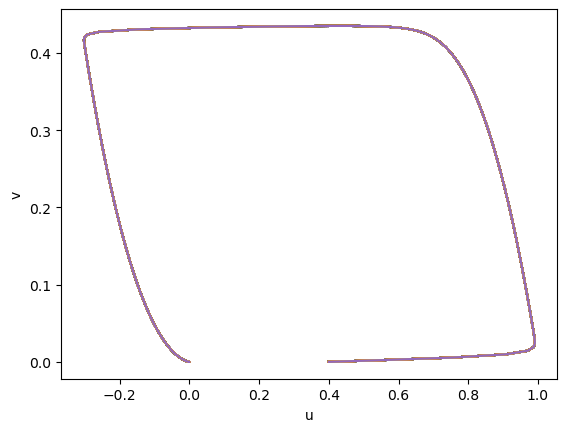

20134


In [24]:
c1 = c1.flatten()
print(c1.shape)
u_plot = np.array(u_coarse_grained[c1, :])
v_plot = np.array(v_coarse_grained[c1, :])

# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))

(40000, 6000)


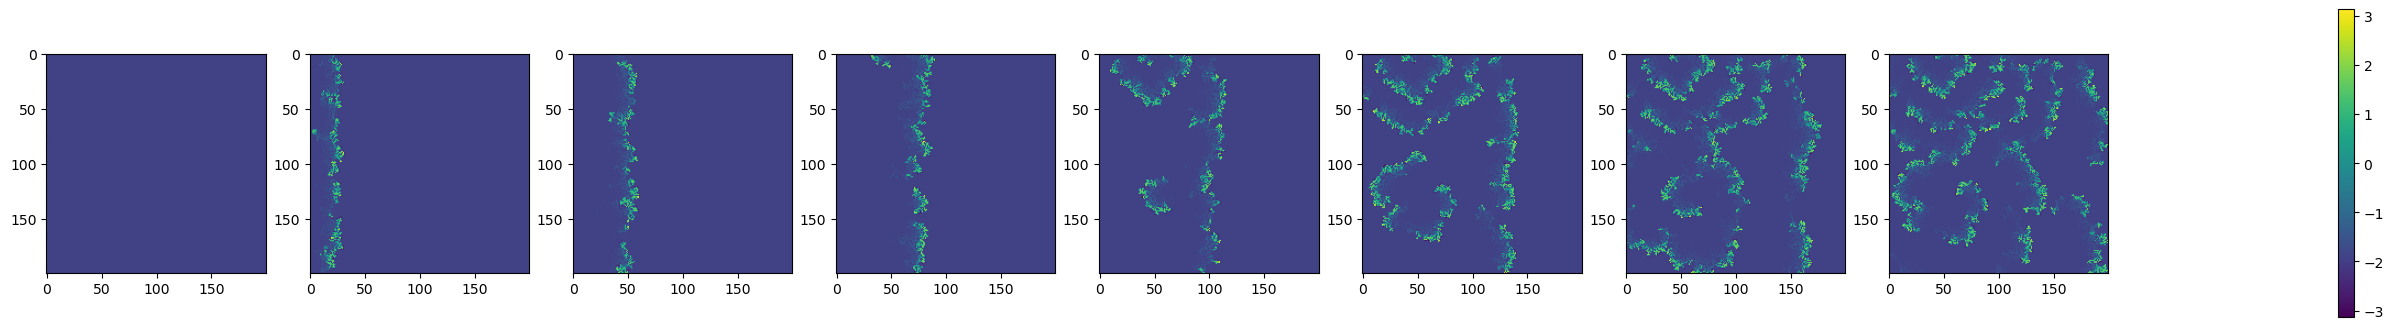

In [13]:
theta= jnp.arctan2(u_coarse_grained-0.4, v_coarse_grained-0.15)
print(theta.shape)

fig, axs = plt.subplots(1,9,figsize=(30,4))
min = theta.min()
max = theta.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(theta[:, int((i/len(axs)*len(sol.ts)))].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [14]:
theta=theta.reshape(200,200,6000)
top_charge=compute_top_charge(theta)

In [15]:
print(np.max(top_charge))

2.0000002


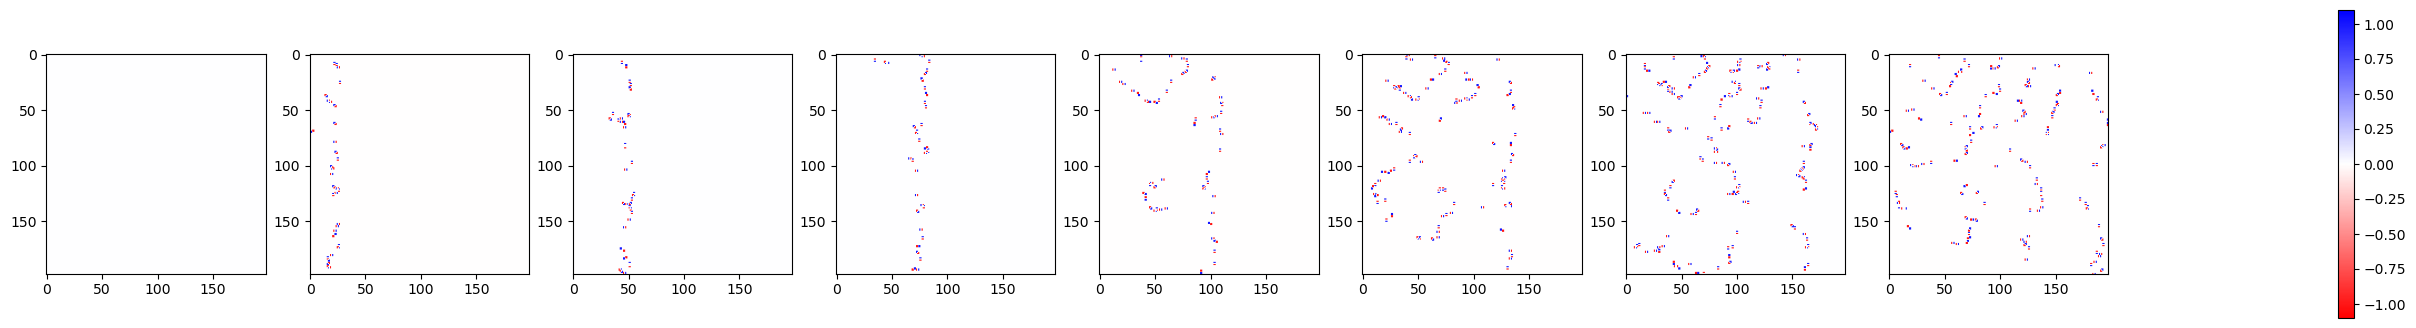

In [43]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap that transitions from red to white to blue
colors = [(1, 0, 0),  # Red for negative values
          (1, 1, 1),  # White at zero
          (0, 0, 1)]  # Blue for positive values

# Create the colormap with three defined colors
cmap = LinearSegmentedColormap.from_list('custom_white_zero', colors, N=256)

fig, axs = plt.subplots(1, 9, figsize=(30, 4))
min_val = -1.1
max_val = 1.1

# Normalize the colormap to ensure white is exactly at zero
norm = plt.Normalize(vmin=min_val, vmax=max_val)
top_charge=top_charge
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(top_charge[int((i/len(axs)*len(sol.ts))), :, :], cmap=cmap, norm=norm)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
plt.savefig("top_charge_philip.png")
plt.show()

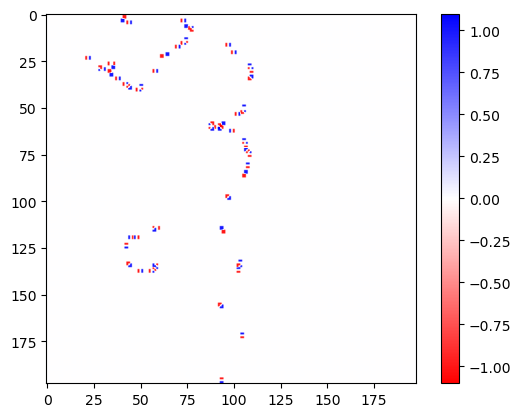

In [44]:
plt.imshow(top_charge[2611,:,:], cmap=cmap, norm=norm)
plt.colorbar()
print()

In [ ]:
#functions to debug the topological charge calculations

def count_elements_above_threshold(array, threshold):


    count = np.sum(np.abs(array) > threshold)
    return count


threshold = 2
count = count_elements_above_threshold(top_charge, threshold)
print(count)

176


In [20]:
print(np.max(top_charge[0,:,:]))

1.5178198e-07


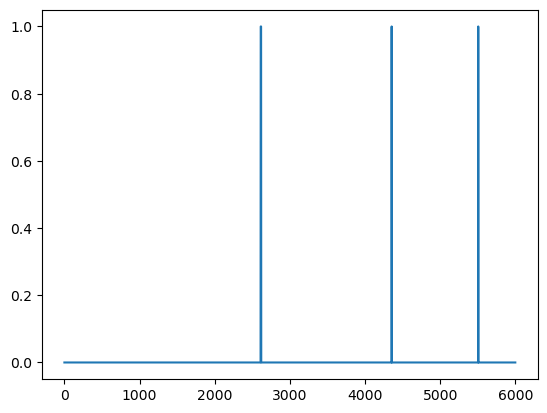

In [ ]:
#count of singularities: just counts how many singularities are there because of transient wavebreaks and not because of actual spirals

def count_coupled_clusters(top_charge, threshold=1, eps=4, min_samples=1):
    """
    Count coupled clusters of negative and positive topological charges in each frame.

    Parameters:
    - top_charge: 3D array (T, N, N) with topological charges.
    - threshold: Minimum absolute value of topological charge to be considered significant.
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
    - coupled_cluster_counts: List of coupled cluster counts per frame.
    """
    T, N, _ = top_charge.shape
    coupled_cluster_counts = []

    for t in range(T):
        frame = top_charge[t, :, :]
        
        # Find indices of significant charges
        significant_mask = np.abs(frame) > threshold
        indices = np.column_stack(np.nonzero(significant_mask))
        charges = frame[significant_mask]
        
        if len(indices) == 0:
            coupled_cluster_counts.append(0)
            continue
        
        # Apply DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(indices)
        labels = clustering.labels_
        
        # Count clusters with both positive and negative charges
        unique_clusters = np.unique(labels)
        cluster_count = 0
        
        for cluster in unique_clusters:
            if cluster == -1:
                continue  # Skip noise points
            
            cluster_charges = charges[labels == cluster]
            has_positive = np.any(cluster_charges > 0)
            has_negative = np.any(cluster_charges < 0)
            
            if has_positive and has_negative:
                cluster_count += 1
        
        coupled_cluster_counts.append(cluster_count)
    
    return coupled_cluster_counts



coupled_cluster_counts = count_coupled_clusters(top_charge, threshold=1.3)
plt.plot(coupled_cluster_counts)

In [ ]:
a=np.nonzero(count_coupled_clusters)[0]

print(a)

[2611 2612 2613 2614 2615 2616 2617 4354 5506]


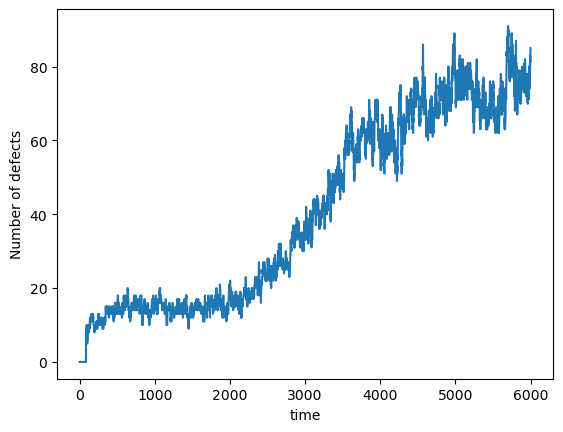

In [27]:
plt.plot(coupled_cluster_counts)
plt.xlabel('time')
plt.ylabel('Number of defects')
plt.savefig('Number_defects_trial.png')

# Entropy and co 

In [ ]:
def shannon_entropy(u_sol):
    # Perform the 3D shifted Fourier transform
    u_sol_fft = np.fft.fftshift(np.fft.fftn(u_sol.reshape(N_x, N_y, -1)))
#Shannon entropy
    power_sp= np.abs(u_sol_fft)**2
    power_norm=power_sp/np.sum(power_sp)
    entropy=-np.sum(power_norm*np.log(power_norm))
    return entropy

# Defining the right boundary of the frame
lista=[]
N=200*200
for i in range(N):
    if i%N_x==N_x-1:
        lista.append(i)
#defining function to calculate the 'velocity' of the wave
def tempi(u_sol, dts):
    a=0
    for j in range(dts):

        u1=np.array(u_sol[:,j])
        for i in lista:
            if u1[i]!=0:
                a=1
                return j
    if a==0:
        return dts  #returns the last time if the wave doesn't reach the right boundary
    


def conditional_entropy(u_sol):
    u_sol_fft = np.fft.fftshift(np.fft.fftn(u_sol.reshape(N_x, N_y, -1)))
    power_sp = np.abs(u_sol_fft)**2
    power_norm = power_sp / np.sum(power_sp)
    p_k = np.sum(power_norm, axis=2)
    p_k[p_k == 0] = np.finfo(float).eps

    marginal_kx_ky_expanded = np.expand_dims(p_k, axis=2)
    conditional_distribution = power_norm / marginal_kx_ky_expanded
    conditional_entropy = 0.0

    for kx in range(conditional_distribution.shape[0]):
        for ky in range(conditional_distribution.shape[1]):
            p_omega_given_k = conditional_distribution[kx, ky]
            p_omega_given_k_nonzero = p_omega_given_k[p_omega_given_k > 0]
            entropy_term = -np.sum(p_omega_given_k_nonzero * np.log(p_omega_given_k_nonzero))
            conditional_entropy += p_k[kx, ky] * entropy_term

    return conditional_entropy



In [ ]:
u_sol=[]
entropy_u=[]
entropy_v=[]
frames=[]

D=0
N_y=200
for d in range(40):
    L1, c1=generate_laplacian(N_x, N_y, conduction_block_threshold=D,boundary_condition="no-flux",sparse_matrix=True, seed=d)
    sol= solve_heart(T=3000,a=3, b=0.05, Du=0.04, L=L1)
    u_sol=sol.ys[:,:N].T
    v_sol=sol.ys[:,N:].T
 
    entropy_u.append(shannon_entropy(u_sol))
    entropy_v.append(shannon_entropy(v_sol))
    frames.append(tempi(u_sol,dts))
    D+=0.02


32


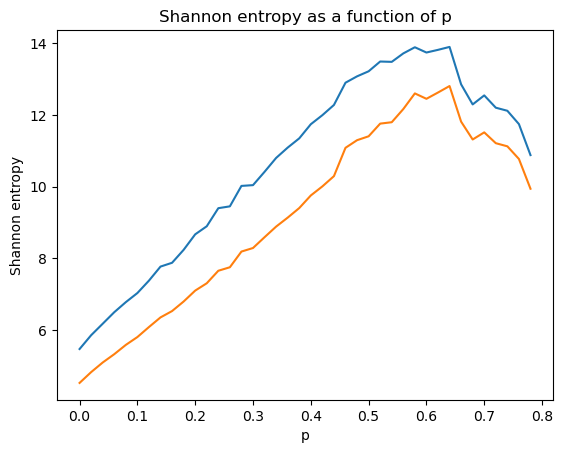

[5.47126788666964, 5.856433846539968, 6.176653276118139, 6.498541812827065, 6.779239988445151, 7.033138183509885, 7.3794143274343735, 7.771164702085293, 7.877434300795918, 8.23843648358658, 8.670606795385815, 8.896152297356759, 9.400615286269698, 9.451823530803686, 10.022168779732127, 10.043566117606838, 10.415586011619554, 10.802482042679882, 11.09080983543932, 11.348743571769232, 11.742889396033531, 11.995542271981138, 12.28056726135333, 12.901477930253979, 13.079015432426155, 13.219942492865718, 13.492477212920102, 13.48302288122614, 13.718921183348709, 13.89052083681153, 13.743488859501069, 13.818101661558629, 13.89980003419093, 12.85580621996821, 12.295509341066381, 12.54722771265402, 12.204217971579988, 12.118430702072416, 11.7467098962782, 10.881616069490661]


In [8]:
minu=np.min(entropy_u)
maxu=np.max(entropy_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(entropy_u))
#print(np.argmax(entropy_v))
plt.plot(np.arange(0,0.80,0.02),entropy_u,label='Entropy of u')
plt.plot(np.arange(0,0.80,0.02),entropy_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()
print(entropy_u)
#print(entropy_v)

19


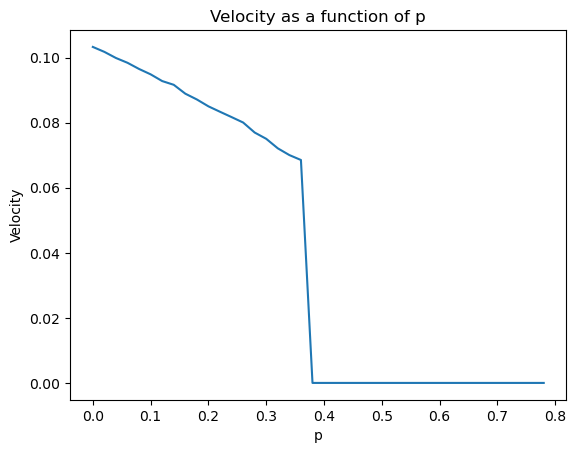

In [ ]:
frames=np.array(frames)

velocity = np.where(frames != dts, 200 / frames, 0) #set velocity to zero for waves which did not reach the end of the frame
plt.plot(np.arange(0,0.80,0.02),velocity)
plt.xlabel('p')
plt.ylabel('Velocity')
plt.title('Velocity as a function of p')
print(np.argmin(velocity))


# Bunch of realisations of the system with different p 

In [ ]:
act=[]
N_y=200
N=200*200

#calculate how many pixels are active at the end of the simulation
for d in range(30):
    L1, c1=generate_laplacian(N_x, N_y, conduction_block_threshold=0.43,boundary_condition="no-flux",sparse_matrix=True, seed=d)
    sol= solve_heart(T=5000,a=3, b=0.05, Du=0.04, L=L1)
    u_sol=sol.ys[:,:N].T
    
    act.append(np.sum(np.abs(u_sol[:,-1])))


In [ ]:
#Bunch of values of activity for different simulations

act04=[0.009923362, 0.0016705038, 0.009423414, 0.006053726, 0.0021573352, 0.013834376, 0.0015517543, 0.0008823167, 0.0071933717, 0.0025135223, 0.0037465505, 0.020624869, 5338.9175, 0.037836097, 0.0012640097, 0.015526744, 0.044260286, 0.025760598, 0.00276638, 5003.392, 0.010103817, 0.0008076201, 0.010210669, 0.0051388964, 0.015452754, 0.006425097, 0.038676098, 5725.257, 5131.0967, 0.011531703]
act041=[0.004086318, 0.011906181, 0.018213917, 0.012153958, 0.022822933, 0.045725156, 0.005815033, 0.004877297, 0.017329507, 0.0026090639, 0.0033905758, 0.0047255233, 5270.944, 0.004327442, 0.00088896975, 0.008442832, 0.009531457, 0.005999746, 0.015000751, 4564.1006, 0.0052969907, 0.00078559166, 0.029975042, 0.01605004, 1744.5625, 0.010734483, 0.002536308, 5637.3696, 5059.8926, 0.0072051603]
act055=[2833.4622, 2559.9487, 3080.4683, 2808.6064, 2871.4463, 2968.2166, 2888.7969, 2273.2969, 3403.7773, 1078.5526, 2768.5623, 2333.819, 1981.3336, 2847.2637, 1935.8997, 1848.2286, 1730.2648, 2031.3787, 2515.415, 1394.2374, 3342.2322, 3493.067, 2811.4663, 1764.7651, 2465.8438, 2767.7266, 3162.408, 3687.1104, 3188.3025, 3193.9565]
act057=[1786.5548, 1776.421, 2611.809, 1527.6613, 1074.5784, 3223.501, 260.5359, 1074.8702, 2555.4817, 1151.6772, 249.36255, 1720.0121, 655.7163, 1872.544, 1485.1387, 402.0334, 0.00566916, 1241.3264, 1424.9019, 1063.6545, 1515.4995, 1117.7535, 1046.59, 1460.1007, 1429.0635, 1329.3091, 331.32486, 2541.7998, 2610.3232, 2407.0645]
act058=[1085.8999, 1629.5762, 804.3769, 1730.2219, 1617.5505, 2202.5542, 164.55045, 502.39362, 1918.9631, 858.374, 120.60353, 1502.4304, 526.12555, 638.8281, 659.0477, 0.002338938, 0.0024756195, 408.59763, 1185.8556, 377.73505, 692.70166, 855.1096, 316.789, 649.08704, 1264.2697, 1465.1816, 113.00742, 1243.915, 1422.5116, 1184.888]
act059=[0.039803885, 919.28564, 545.4691, 1116.6805, 460.33704, 0.00089235406, 160.03995, 139.1206, 695.74615, 0.0037527564, 0.013066407, 631.7642, 107.05286, 0.0209953, 753.7185, 0.0035047971, 0.0015250924, 86.72422, 186.01663, 181.00757, 777.4796, 697.86005, 121.25394, 945.4887, 866.44037, 1490.3878, 0.0022879401, 1132.0448, 497.9514, 280.91193]
act06=[0.003914822, 0.0077085644, 522.9938, 399.55658, 140.30952, 0.0052299695, 371.75616, 50.578346, 0.0010606318, 0.0008021454, 0.024293236, 384.3217, 0.012965788, 0.0009316916, 0.005710764, 0.0019897532, 0.020151975, 84.2617, 0.0049646846, 0.035888966, 543.45984, 147.9135, 135.00233, 557.0675, 629.25604, 1054.07, 0.0123485485, 751.8237, 0.019012656, 0.0005694717]

act056=[2660.3162, 2817.8848, 3282.2224, 2575.5994, 3134.2527, 3547.097, 4099.309, 2487.4448, 3692.5715, 2195.7139, 2883.4036, 2636.6992, 2339.2642, 2495.978, 2823.6687, 3053.7578, 2417.684, 2513.4185, 2566.618, 2347.4248, 3544.0962, 2944.2012, 2892.9246, 2581.4878, 2344.2388, 2276.4666, 1948.5901, 2499.0222, 4151.71, 3822.9458]
act054=[2432.3643, 4003.7383, 4252.993, 1633.3854, 2833.0142, 3202.5024, 2207.1582, 2759.023, 2609.5127, 3912.0737, 3755.0156, 3262.9302, 2848.879, 4373.6816, 2808.927, 3177.3782, 2659.0107, 2975.2712, 4214.392, 3333.2217, 3673.326, 4186.993, 3971.8853, 3137.1113, 3562.1616, 3385.2495, 2683.6187, 4518.2344, 4812.2427, 3885.5498]
act053=[4229.559, 4221.2085, 4411.0312, 4815.5938, 3886.494, 4540.203, 4514.6064, 2746.8994, 2568.7625, 4760.5967, 3422.3713, 3668.9253, 4755.195, 4186.1577, 3057.9788, 3566.9333, 3251.3887, 4557.017, 4294.2715, 3179.8247, 3983.796, 4744.218, 4260.2114, 2839.7502, 4652.4883, 3564.4783, 4403.8, 3839.7212, 4510.4336, 3978.6206]
act052=[3289.5498, 4685.8667, 3620.7847, 2517.9036, 4196.553, 4706.21, 4546.017, 2956.583, 2628.3552, 2979.4795, 4559.249, 3960.039, 4748.4155, 4271.6777, 2206.1135, 2965.569, 3194.5825, 3925.342, 4510.1235, 3139.0884, 5198.145, 5002.414, 3554.7173, 3223.4617, 5278.603, 3763.9656, 4622.694, 4513.5864, 3685.6853, 4185.581]
act051=[3442.8154, 4644.5454, 3714.1926, 3518.913, 4252.5303, 4995.0586, 3119.0278, 3508.7576, 2866.7656, 2407.5688, 3664.0178, 4481.247, 4691.497, 4349.565, 2015.6228, 4355.917, 2234.358, 4171.273, 4514.6855, 3202.4043, 4520.294, 5274.2295, 3602.0308, 3899.9731, 3540.717, 3859.8826, 5043.982, 3889.5476, 4015.8252, 3566.208]
act05=[3844.2144, 5119.75, 4463.863, 4634.6797, 5148.3975, 3516.725, 3555.8096, 3201.8977, 2977.4814, 3305.7915, 3346.336, 4582.0615, 5210.668, 5115.37, 2820.0664, 3589.4124, 3195.9553, 3141.4695, 4622.1855, 3241.0723, 5035.171, 4902.0425, 4042.1045, 4202.271, 3171.7576, 4755.0376, 4364.643, 4539.864, 3020.04, 3668.1326]
act049=[4454.1074, 5196.639, 3757.2583, 4493.3804, 3146.687, 5071.127, 4287.6846, 3401.1055, 4197.484, 2910.7073, 2404.6392, 3963.482, 5436.237, 5611.878, 4949.7583, 3458.5852, 3417.803, 3133.9976, 2378.4119, 5417.3057, 3570.0625, 5074.8037, 4299.793, 5218.8555, 2729.0693, 3667.6875, 3759.7703, 4360.8306, 3542.4844, 3914.9043]
act048=[4731.7246, 5244.777, 4218.726, 0.006416303, 3598.7817, 5150.168, 0.011897925, 4789.4517, 3274.4397, 5722.3057, 3563.0032, 0.011878576, 4715.654, 4350.2495, 4880.5195, 4933.207, 3920.6782, 3477.915, 4062.6436, 3169.3853, 4147.864, 5499.482, 4643.8857, 5283.7695, 3106.9004, 3971.3643, 3820.1958, 5603.225, 5060.5713, 3960.6548]
act047=[4827.9727, 3494.5894, 5615.564, 0.023840785, 3630.7131, 5260.841, 0.0010274609, 4384.1504, 4316.8726, 2820.0894, 3504.5151, 4683.2817, 4145.411, 4215.553, 5097.3906, 5407.5312, 4833.3457, 0.0016060957, 4826.131, 3013.4255, 4445.0137, 5442.6562, 0.004891062, 5119.239, 0.0009779349, 3654.8198, 4475.6025, 6004.3867, 5596.779, 3973.653]
act046=[5319.2075, 5139.8584, 4952.2734, 0.0016110804, 0.001426761, 5357.6416, 4197.949, 4015.545, 2357.3213, 2602.7874, 3488.291, 4786.653, 5210.802, 4763.5073, 5192.498, 3710.734, 4823.4463, 0.0007656492, 3634.5542, 3422.2305, 4375.532, 4103.5967, 4156.5, 4501.117, 0.0022301571, 4347.5693, 3821.027, 4129.3584, 0.005581368, 4470.3457]
act045=[0.018186664, 6177.8438, 5740.265, 0.00071115216, 0.006400124, 5133.212, 4166.988, 4327.1265, 2396.234, 0.0033362466, 4920.3394, 4269.164, 4170.2676, 5250.5503, 5703.046, 0.007064334, 2897.4988, 0.050848205, 0.0042037778, 3014.3218, 0.0025189223, 6038.8984, 0.0020699499, 4576.618, 0.011010766, 4363.0176, 4142.8394, 4818.713, 5533.3613, 0.0026999053]
act044=[0.00982952, 6261.5996, 4646.049, 0.0060859155, 0.002848836, 0.002934521, 0.00301494, 4460.507, 2981.9243, 0.0044710254, 4862.717, 3671.8337, 5317.4062, 5336.4653, 3795.1306, 0.006647428, 2694.096, 0.001128682, 0.044937793, 4104.9785, 4585.945, 5884.1167, 0.004721652, 4755.659, 0.007697629, 4555.838, 0.001471171, 5242.981, 5541.599, 0.0035848538]
act043=[0.009416501, 5628.997, 4901.536, 0.0013795051, 0.015074809, 0.015201429, 5479.409, 4935.651, 0.0034613404, 0.01575435, 5054.793, 4049.0444, 6469.657, 0.005988351, 3234.5623, 0.006346454, 0.00946958, 0.065875664, 0.058527134, 4007.8708, 0.0029437055, 0.0048120786, 0.08392802, 0.0019354454, 0.0044939676, 0.0042904913, 0.008991112, 5548.6724, 5593.1177, 0.0012864644]

## Fourier transform and order parameters
1) 3D Fourier transform : power spectrum concentration

In [ ]:
#dominant wavenumber and power spectrum concentration
def dominant_wavenumber(u_sol_fft):
    power_sp= np.abs(u_sol_fft)**2
    kmax=np.argmax(power_sp)
    kmax_2d = np.unravel_index(kmax, power_sp.shape)
    psi=power_sp[kmax_2d]/ np.sum(power_sp)
    return psi


0.022233007623218153


## 2D Fourier transform

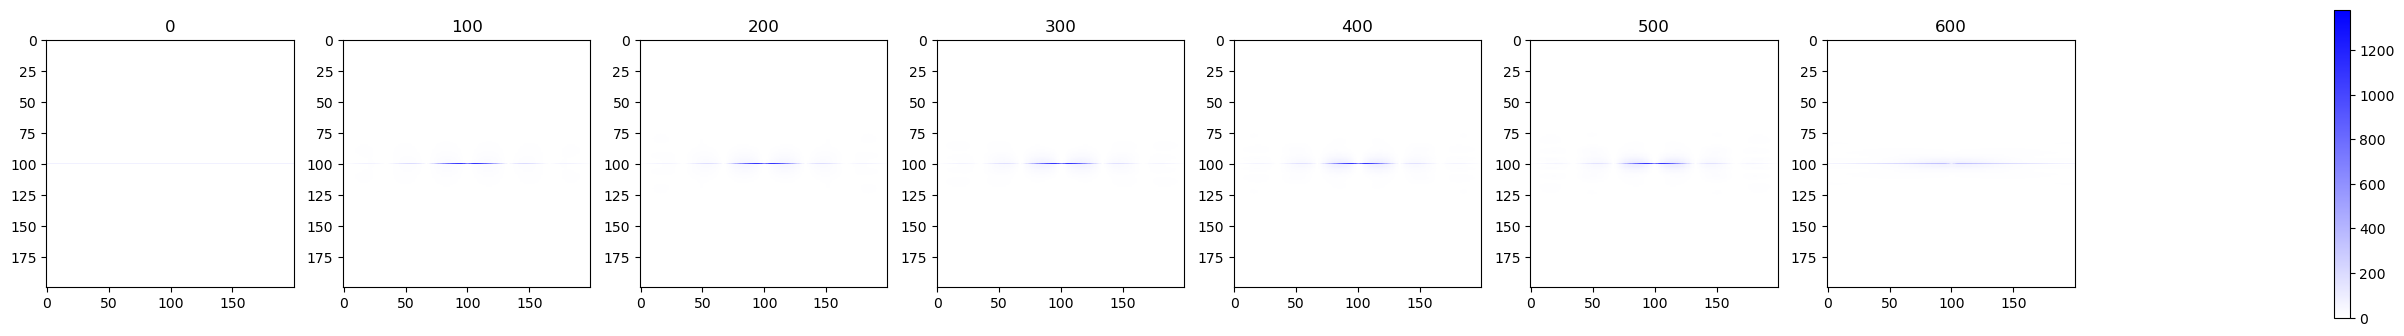

In [69]:

u_sol = sol.ys[:,:N].T 
# Perform the 2D Fourier transform on each temporal frame
u_sol_fft = np.fft.fftshift(np.fft.fft2(u_sol.reshape(N_x, N_y, -1), axes=(0, 1)), axes=(0, 1))

# Plot the 2D Fourier transform as a function of time
fig, axs = plt.subplots(1, 8, figsize=(30, 4))
min_val = np.abs(u_sol_fft).min()
max_val = np.abs(u_sol_fft).max()

for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(np.abs(u_sol_fft[:, :, int(i / len(axs) * u_sol_fft.shape[2])]), vmin=min_val, vmax=max_val, cmap=cmap, interpolation='nearest')
    ax.set_title(str(int(i / len(axs) * u_sol_fft.shape[2])))
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
plt.show()
v_sol = sol.ys[:,N:].T 


## 2D Fourier transform of the u averaged over the y axis

(200, 200, 800)


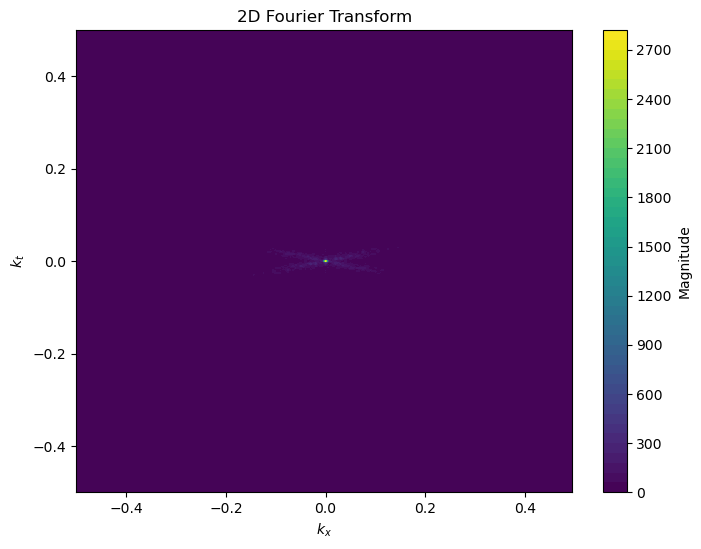

In [9]:
u_sol = sol.ys[:,:N].T 
u_p=u_sol.reshape(N_x, N_y, -1)
print(u_p.shape)
T=800
# Compute the mean of u_p over the y-axis for each timestep
matrix = np.mean(u_p, axis=1)

# Step 1: Compute the 2D Fourier Transform
fft_matrix = np.fft.fft2(matrix)

# Step 2: Shift the zero-frequency component to the center
fft_shifted = np.fft.fftshift(fft_matrix)

# Step 3: Calculate the Fourier space frequencies
kx = np.fft.fftshift(np.fft.fftfreq(N_x))
kt = np.fft.fftshift(np.fft.fftfreq(T))

# Step 4: Create the grid of Fourier space coordinates
KX, KT = np.meshgrid(kx, kt, indexing='ij')

# Step 5: Plot the magnitude of the shifted Fourier transform
plt.figure(figsize=(8, 6))
plt.contourf(KX, KT, np.abs(fft_shifted), levels=50, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('2D Fourier Transform')
plt.xlabel(r'$k_{x}$')
plt.ylabel(r'$k_{t}$ ')
plt.show()

In [34]:
#dominant wavenumber and power spectrum concentration
power_sp= np.abs(fft_shifted)**2
kmax=np.argmax(power_sp)
kmax_2d = np.unravel_index(kmax, power_sp.shape)
psi=power_sp[kmax_2d]/ np.sum(power_sp)
print(psi)

psi1=0.39514010945587014
psi2=0.678211870040056

0.678211870040056
